# Decision Tree 

16307110216 Ruian He

### Extract data from downloaded files

First we use `pandas` module to read from the csv file and take a look at the data.

In [25]:
import pandas as pd

file_path = '../breast_cancer/data.csv'
df = pd.read_csv(file_path)
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness

### Preprocessing the data

As the diagnosis is a string, we must binarize the value for later calculation.

In [26]:
df['target'] = df['diagnosis']=='M'

Then we split the dataset into training and testing set using `sklearn` module.

In [27]:
from sklearn.model_selection import train_test_split

X = df[df.columns[2:-2]]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(455, 30) (455,) (114, 30) (114,)


### Decision Tree Model

We take the ID3 algorithm with information gain as a criterion for choosing features. 

Information gain is the reduction in entropy or surprise by transforming a dataset and is often used in training decision trees. Information gain is calculated by comparing the entropy of the dataset before and after a transformation. 


And entropy, as it relates to machine learning, is a measure of the randomness in the information being processed and is defined as follows.

![entropy](https://miro.medium.com/max/391/1*nNY_7_aWRwp8E2DyGduEPg.png)



In [98]:
import numpy as np

class DecisionTree(object):
    class Node(object):
        # the data 
        def __init__(self,sample_index,feature_index):
            self.sample_index = sample_index
            self.feature_index = feature_index

            self.childs = []
            self.predict = None
            
            self.gain = 0
            self.feature = None
            self.threshold = None 
        
    def __init__(self, gain_threshold=1e-1):
        self.X = None
        self.y = None
        self.root = None
        
        self.gain_threshold = gain_threshold
        
    def _entropy(self, y):
        c = np.bincount(y)
        p = c[np.nonzero(c)] / y.size
        return -np.sum(p * np.log2(p))
    
    def _conditional_entropy(self, feature, y):
        feature_values = np.unique(feature)
        h = 0
        for value in feature_values:
            y_sub = y[feature == value]
            h += y_sub.size / y.size * self._entropy(y_sub)
        return h
        
    def _information_gain(self, feature, y):
        return self._entropy(y) - self._conditional_entropy(feature,y)
    
    def _select_threshold(self, X, y, feature):
        feature_values = np.unique(X[feature])
        
        best_gain = 0
        best_threshold = None
        for value in feature_values:
            pred_feature = X[feature]>value
            gain = self._information_gain(pred_feature,y)
            if gain > best_gain:
                best_gain = gain
                best_threshold = value
            
        return best_threshold, best_gain
    
    def _select_feature(self, node):
        X = self.X.loc[node.sample_index,node.feature_index]
        y = self.y.loc[node.sample_index] 
        
        for feature in node.feature_index:
            threshold,gain = self._select_threshold(X, y, feature)
            if gain > self.gain_threshold and gain > node.gain:
                node.gain = gain
                node.feature = feature
                node.threshold = threshold
                
        return node.feature,node.threshold
    
    def _build_tree(self,node):
        X = self.X.loc[node.sample_index,node.feature_index]
        y = self.y.loc[node.sample_index]
        
        print("building node with %d examples..."%(len(X.index)))
        
        feature,threshold = self._select_feature(node)
        
        if feature is not None:
            feature_index = node.feature_index[:]
            feature_index.remove(feature)
            node.childs.append(self._build_tree(self.Node(X.index[X[feature] > threshold], feature_index)))
            node.childs.append(self._build_tree(self.Node(X.index[X[feature] <= threshold],feature_index)))
        else:
            node.predict = np.argmax(np.bincount(y))
            
        return node
    
    def train(self, X, y):
        self.X = X
        self.y = y
        
        self.root = self.Node(list(X.index),list(X.columns))
        self._build_tree(self.root)
        
        print("build complete!")
    
    def _predict_node(self, x, node):
        if node.feature is None:
            return node.predict
        elif x[node.feature] > node.threshold:
            return self._predict_node(x, node.childs[0])
        else:
            return self._predict_node(x, node.childs[1])
    
    def predict(self, X):
        return [self._predict_node(X.loc[index],self.root) for index in X.index]         

### Training and Testing

Now we get the model and the data,then we can start training and testing.Moreover, we can look into accuracies in both classes and print the confusion matrix.

In [99]:
from sklearn.metrics import f1_score,accuracy_score

model = DecisionTree()
model.train(X_train,y_train)

y_pred = model.predict(X_test)
print("The model accuracy is:",accuracy_score(y_test,y_pred))
print("The f1 score is:",f1_score(y_test,y_pred))

building node with 455 examples...
building node with 132 examples...
building node with 125 examples...
building node with 7 examples...
building node with 4 examples...
building node with 3 examples...
building node with 323 examples...
building node with 74 examples...
building node with 41 examples...
building node with 28 examples...
building node with 22 examples...
building node with 6 examples...
building node with 3 examples...
building node with 3 examples...
building node with 13 examples...
building node with 11 examples...
building node with 2 examples...
building node with 33 examples...
building node with 5 examples...
building node with 3 examples...
building node with 2 examples...
building node with 28 examples...
building node with 249 examples...
build complete!
The model accuracy is: 0.9122807017543859
The f1 score is: 0.9


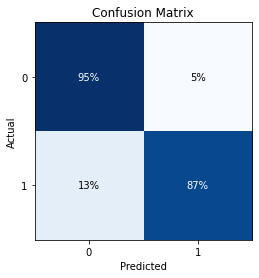

In [130]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots()
ax.imshow(cm,cmap=plt.cm.Blues)

ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=range(10), yticklabels=range(10),
           title='Confusion Matrix',
           ylabel='Actual',
           xlabel='Predicted')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, 
                s = format(int(cm[i, j]*100 + 0.5) , 'd') + '%', 
                ha = "center", 
                va = "center", 
                color = "white"  if cm[i, j] > 0.5 else "black")
fig.show()

And we can look at the structure of the decision tree.

In [134]:
from graphviz import Digraph
from time import time
from pickle import dump

def build_tree(graph,node):
    name = str(time()) 
    if node.feature is None:
        graph.node(name = name, label = 'predict:'+str(node.predict)+'\nnum:'+str(len(node.sample_index)))
    else:
        graph.node(name = name, label = 'feature:'+str(node.feature)+'\nnum:'+str(len(node.sample_index))+' gain:%.2f'%(node.gain))
        lchild = build_tree(graph,node.childs[0])
        rchild = build_tree(graph,node.childs[1])
        graph.edge(name,lchild,label='>%.2f'%(node.threshold))
        graph.edge(name,rchild,label='<=%.2f'%(node.threshold))
    return name
graph = Digraph()
build_tree(graph,model.root)
graph.save()

'Digraph.gv'